# Preparation

In [ ]:
# Install dependencies
%pip install -q -U ipywidgets transformers tqdm
%pip install -q -U seqeval
%pip install -q -U accelerate
%pip install -q -U transformers[torch]
%pip install -q --upgrade -U torch torchvision torchaudio torchtext
%pip install -q dill==0.3.1.1
%pip install -q numpy==1.14.3
%pip install -q pyarrow==0.3.8
%pip install -q multiprocess==0.70.16
%pip install -q -U datasets==2.6.0
%pip install -q fsspec==2023.9.2
%pip install -q optuna
%pip install -q torch
%pip install -q datasets
%pip install -q collections
%pip install -q nltk

In [188]:
import datasets
import torch
import torchtext
from datasets import load_dataset, Features, Value
import matplotlib.pyplot as plt
from collections import Counter
import os
import nltk
import subprocess
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
from transformers import AutoTokenizer
import transformers
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import dill
from transformers import DataCollatorForTokenClassification
from datasets import load_metric
import numpy as np
import gc
import torch.nn as nn
from datasets import DatasetDict, Dataset
from transformers import BertForTokenClassification
from transformers import BertTokenizerFast
from optuna import create_study, Trial


## Set Seed and CUDA

In [3]:
print(datasets.__version__)

2.18.0


In [4]:
SEED = 1234
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("PyTorch Version: ", torch.__version__)
print("torchtext Version: ", torchtext.__version__)
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'}.")

PyTorch Version:  2.2.1+cu121
torchtext Version:  0.17.1+cpu
Using GPU.


## Data Prep

### Download the Dataset
this will download the huggingface dataset ready for use

In [5]:
dataset = load_dataset("surrey-nlp/PLOD-CW", cache_dir=None, download_mode="force_redownload")

Generating train split:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153 [00:00<?, ? examples/s]

In [6]:
print(type(dataset))

<class 'datasets.dataset_dict.DatasetDict'>


### Get Label List
this gets the list of labels for the dataset

In [7]:
label_list = ['B-O', 'B-AC', 'B-LF', 'I-LF']
print(label_list)

['B-O', 'B-AC', 'B-LF', 'I-LF']


### Split The Set Into Train, Val and Test Sets

In [8]:
train = dataset['train']
print(f"train size: {len(train)}")
val = dataset['validation']
print(f"val size: {len(val)}")
test = dataset['test']
print(f"test size: {len(test)}")

def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

from collections import Counter
flat = flatten(train["ner_tags"])
print(Counter(flat))

train size: 1072
val size: 126
test size: 153
Counter({'B-O': 32971, 'I-LF': 3231, 'B-AC': 2336, 'B-LF': 1462})


## Data visualization
Here I visualize the dataset to be used for this course work and analyse its features

In [ ]:
def analyze_nlp_dataset(data, output_folder):
  """
  Analyzes and visualizes an NLP dataset with tokens, POS tags, and NER tags.

  Args:
      data: A dictionary containing separate lists for tokens, POS tags, and NER tags.
          - data["tokens"]: A list of lists of tokens.
          - data["pos_tags"]: A list of lists of POS tags.
          - data["ner_tags"]: A list of lists of NER tags.
      output_folder: The folder path to save generated plots.
  """

  try:
    os.mkdir(output_folder)
  except FileExistsError:
    pass  # Folder already exists, continue

  # POS Tag Analysis
  all_pos_tags = [pos_tag for row in data["pos_tags"] for pos_tag in row]
  pos_tag_counts = Counter(all_pos_tags)

  # Plot POS tag distribution
  plt.figure(figsize=(8, 6))
  plt.pie(pos_tag_counts.values(), labels=pos_tag_counts.keys(), autopct="%1.1f%%")
  plt.title("POS Tag Distribution")
  plt.savefig(f"{output_folder}/pos_tag_distribution.png")
  plt.close()

  # NER Tag Analysis
  all_ner_tags = [ner_tag for row in data["ner_tags"] for ner_tag in row]
  ner_tag_counts = Counter(all_ner_tags)

  # Plot NER tag distribution (if any named entities exist)
  if ner_tag_counts:
    plt.figure(figsize=(8, 6))
    plt.bar(ner_tag_counts.keys(), ner_tag_counts.values())
    plt.xlabel("NER Tag")
    plt.ylabel("Frequency")
    plt.title("NER Tag Distribution")
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.savefig(f"{output_folder}/ner_tag_distribution.png")
    plt.close()
  else:
    print("No named entity tags found in the data for NER tag analysis.")

  # Analysis of POS tags within NER tags
  pos_in_ner_tags = {}
  for tokens, pos_tags, ner_tags in zip(data["tokens"], data["pos_tags"], data["ner_tags"]):
    for token, pos_tag, ner_tag in zip(tokens, pos_tags, ner_tags):
      if ner_tag and ner_tag != "O":  # Consider only named entity tags (excluding "O")
        pos_in_ner_tags.setdefault(ner_tag, []).append(pos_tag)

  # Calculate POS tag proportions within each NER tag (if data exists)
  if pos_in_ner_tags:
    for ner_tag, pos_tag_list in pos_in_ner_tags.items():
      pos_tag_counts_in_ner = Counter(pos_tag_list)
      total_count = sum(pos_tag_counts_in_ner.values())
      pos_in_ner_tags[ner_tag] = {tag: count / total_count for tag, count in pos_tag_counts_in_ner.items()}

  # Print insights from POS tags within NER tags analysis (optional)
  if pos_in_ner_tags:
    print("\nInsights from POS tags within NER tags:")
    for ner_tag, pos_tag_proportions in pos_in_ner_tags.items():
      print(f"- NER Tag: {ner_tag}")
      for pos_tag, proportion in pos_tag_proportions.items():
        print(f"  - Proportion of {pos_tag}: {proportion:.2f}")


    # Visualize POS tags within NER tags (if data exists)
  if pos_in_ner_tags:
    for ner_tag, pos_tag_proportions in pos_in_ner_tags.items():
      plt.figure(figsize=(8, 6))
      plt.bar(pos_tag_proportions.keys(), pos_tag_proportions.values())
      plt.xlabel("POS Tag")
      plt.ylabel("Proportion")
      plt.title(f"POS Tag Proportions within NER Tag: {ner_tag}")
      plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
      plt.tight_layout()
      plt.savefig(f"{output_folder}/pos_in_ner_{ner_tag}.png")
      plt.close()

  print("Analysis complete. Plots saved to", output_folder)

In [ ]:
analyze_nlp_dataset(train, "train_set_analysis")
analyze_nlp_dataset(val, "val_set_analysis")
analyze_nlp_dataset(test, "test_set_analysis")

## Data Pre-Processing

### Lemmatization

In [9]:

is_kaggle = (
    "KAGGLE_CLOUD" in os.environ or "KAGGLE_KERNEL_RUN_TYPE" in os.environ
)

if is_kaggle:
    # Download and unzip wordnet
    try:
        nltk.data.find('wordnet.zip')
    except:
        nltk.download('wordnet', download_dir='/kaggle/working/')
        command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
        subprocess.run(command.split())
        nltk.data.path.append('/kaggle/working/')

    # Now you can import the NLTK resources as usual
    from nltk.corpus import wordnet
else:
    nltk.download('wordnet')



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harry\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


the `combine_lists_elementwise` function turns two lists into one, pairing each element elementwise, maintaining the shape of the original list

In [10]:
def combine_lists_elementwise(list_A, list_B):
  """
  Combines two 2D lists of strings element-wise into a 2D list of tuples.

  Args:
      list_A: A 2D list of strings (e.g., [['A', 'A', 'A'], ['A', 'A', 'A']]).
      list_B: Another 2D list of strings with the same dimensions as list_A.

  Returns:
      A 2D list of tuples, where each tuple combines corresponding elements from list_A and list_B.

  Raises:
      ValueError: If the dimensions of list_A and list_B don't match.
  """

  # Check if dimensions match
  if len(list_A) != len(list_B) or len(list_A[0]) != len(list_B[0]):
    raise ValueError("Dimensions of lists A and B must be equal.")

  # Create the resulting list using list comprehension
  return [[(a, b) for a, b in zip(row_a, row_b)] for row_a, row_b in zip(list_A, list_B)]

the nltk lemmatize function takes a certain format for POS_tags so the `convert_pos_tag` maps a POS_tag from the dataset, to one in the required format. Its important to note that alot of data is lost due to the simplicity of the nltk lemmatize function

In [11]:
def convert_pos_tag(nltk_tag):
    """
    Converts NLTK POS tags to the format expected by the lemmatizer.

    Args:
        nltk_tag: The POS tag in NLTK format (e.g., VBG, NNS).

    Returns:
        The corresponding POS tag for the lemmatizer (n, v, a, r, or s) or None if no match.
    """

    tag_map = {
        'NUM': '',  # Number (not handled by lemmatizer)
        'CCONJ': '',  # Coordinating conjunction (not handled)
        'PRON': '',  # Pronoun (not handled)
        'NOUN': 'n',   # Noun
        'SCONJ': '',  # Subordinating conjunction (not handled)
        'SYM': '',   # Symbol (not handled)
        'INTJ': '',  # Interjection (not handled)
        'ADJ': 'a',    # Adjective
        'ADP': '',   # Preposition (not handled)
        'PUNCT': '',  # Punctuation (not handled)
        'ADV': 'r',    # Adverb
        'AUX': 'v',    # Auxiliary verb
        'DET': '',   # Determiner (not handled)
        'VERB': 'v',   # Verb
        'X': '',      # Other (not handled)
        'PART': '',   # Particle (not handled)
        'PROPN': 'n',   # Proper noun
    }
    return tag_map.get(nltk_tag)

the `lemmatize_list` function takes the tokens and their respective pos_tags and lemmatizes the tokens

In [12]:
def lemmatize_list(data, pos_tags):
    """
    Lemmatizes a 2D list of tokens using NLTK.

    Args:
        data: A 2D list of strings (tokens) to be lemmatized.

    Returns:
        A 2D list containing the lemmatized tokens.
    """

    # Initialize the WordNet lemmatizer
    lemmatizer = nltk.WordNetLemmatizer()

    pos_tags = [[convert_pos_tag(tag) for tag in row] for row in pos_tags]

    data = combine_lists_elementwise(data, pos_tags)


    # Lemmatize with part-of-speech information
    lemmatized_data = [[token if pos == '' else lemmatizer.lemmatize(token, pos) for token, pos in row] for row in data]

    return lemmatized_data

### Pre-Processing Pipeline
the `pre_process_data` function applies lemmatization and lowercase to the given data

In [13]:
def pre_process_data(tokens, pos_tags):
    # lemmatize the data
    data = lemmatize_list(tokens, pos_tags)
    # lowercase the data
    data = [[string.lower() for string in row] for row in data]
    return data

In [14]:
from datasets import DatasetDict, Dataset
train_tokens = pre_process_data(train["tokens"], train["pos_tags"])
val_tokens = pre_process_data(val["tokens"], val["pos_tags"])
test_tokens = pre_process_data(test["tokens"], test["pos_tags"])
original_train_tokens = train["tokens"]
original_val_tokens = val["tokens"]
print(f"original train tokens: {original_train_tokens[0]}\npre-processed train tokens: {train_tokens[0]}")
print(f"original val tokens: {original_val_tokens[0]}\npre-processed val tokens: {val_tokens[0]}")

dataset = DatasetDict({
    "train": Dataset.from_dict({"tokens": train_tokens, "pos_tags": train["pos_tags"], "ner_tags": train["ner_tags"]}),
    "validation": Dataset.from_dict({"tokens": val_tokens, "pos_tags": val["pos_tags"], "ner_tags": val["ner_tags"]}),
    "test": Dataset.from_dict({"tokens": test_tokens, "pos_tags": test["pos_tags"], "ner_tags": test["ner_tags"]}),
})

original train tokens: ['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'was', 'developed', '.']
pre-processed train tokens: ['for', 'this', 'purpose', 'the', 'gothenburg', 'young', 'persons', 'empowerment', 'scale', '(', 'gypes', ')', 'be', 'develop', '.']
original val tokens: ['=', 'Manual', 'Ability', 'Classification', 'System', ';', 'QUEST', '=', 'Quest', '-', 'Quality', 'of', 'upper', 'extremity', 'skills', 'test', ';', 'Cont', '=', 'control', ';', 'M', '=', 'male', ',', 'F', '=', 'female', ',', 'V', '=', 'verbal', ',', 'nonV', '=', 'non', '-', 'Verbal', ',', '|Quad', '=', 'quadriplegia', ',', 'Di', '=', 'Diplegia', ',', 'Hemi', '=', 'hemiplegia', '.']
pre-processed val tokens: ['=', 'manual', 'ability', 'classification', 'system', ';', 'quest', '=', 'quest', '-', 'quality', 'of', 'upper', 'extremity', 'skill', 'test', ';', 'cont', '=', 'control', ';', 'm', '=', 'male', ',', 'f', '=', 'female', ',', 'v', '=', 'verbal', 

### Set Task
in this project we are doing Named Entity Recognition so I set the task to "ner"

In [15]:
task = "ner"

# Experiment 1 (Model)
HMM vs BERT

## HMM
The following is the implementation of an HMM model

### Library Import
I am using the nltk library for the HMM implementation

create lists of the sentences and associated tags from the train set

In [16]:
# sentences = train[:]["tokens"]
# tags = train[:]["ner_tags"]

sentences = train_tokens
tags = train[:]["ner_tags"]

print out an example of the first sentence and its tags

In [17]:
print(f"sentence: {sentences[0]}")
print(f"tags: {tags[0]}")

sentence: ['for', 'this', 'purpose', 'the', 'gothenburg', 'young', 'persons', 'empowerment', 'scale', '(', 'gypes', ')', 'be', 'develop', '.']
tags: ['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O']


we generate a character set containing all the characters that can be used in the output of the model

In [18]:
def get_char_set(sentences):
    char_set = set()
    for sentence in sentences:
        for word in sentence:
            for char in word:
                char_set.add(char)
    char_set = list(char_set)
    return char_set

In [19]:
char_set = get_char_set(sentences)
print(f"char_set: {char_set}")

char_set: ['2', '†', 'è', 'ö', 'y', 'l', 'f', '×', ')', 'ß', '♀', '8', '*', 'μ', '®', '′', 'λ', 'κ', '—', ':', '≥', '-', '”', '→', 'γ', '@', '‘', '?', 'r', '[', 'w', ']', 'ν', '%', 'ó', 'u', 'ε', 'i', 'k', '“', '♂', 'x', '>', "'", 'o', '±', '+', 'δ', '"', '∑', 'q', 'g', '·', 'ü', 'é', '§', 'σ', 'd', 't', '&', 'ú', 'ä', 's', '9', '0', 'θ', '¯', '−', '≤', '5', '7', 'm', 'v', '’', '$', '‒', '´', ';', '3', '•', '…', 'a', 'β', '）', '=', 'c', 'p', 'ï', '}', 'b', '（', '∞', '<', 'α', '4', ',', 'µ', '6', '‡', 'ω', '#', 'å', '(', 'z', '°', '/', 'e', '1', 'j', '.', 'í', 'h', 'ã', '–', 'φ', '_', '{', 'n']


In [20]:
trainer = nltk.tag.hmm.HiddenMarkovModelTrainer(states=label_list, symbols=char_set)
data = combine_lists_elementwise(sentences.copy(), tags.copy())
print(data[0])

[('for', 'B-O'), ('this', 'B-O'), ('purpose', 'B-O'), ('the', 'B-O'), ('gothenburg', 'B-LF'), ('young', 'I-LF'), ('persons', 'I-LF'), ('empowerment', 'I-LF'), ('scale', 'I-LF'), ('(', 'B-O'), ('gypes', 'B-AC'), (')', 'B-O'), ('be', 'B-O'), ('develop', 'B-O'), ('.', 'B-O')]


## BERT

The following is the implementation of BERT model

### Tokenizer

In [21]:
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True) # use AutoTokenizer because it defaults to fast tokenizers where as using the BERT Tokenizer does not
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

I need to map the string tokens to numbers

In [22]:
def encode_tags(tag_sequences, possible_tags):
    """
    Encodes a sequence of string tags into a list of corresponding integer tags.

    Args:
        tag_sequences: A 2d list of strings representing numerical tags.
        possible_tags: A list of strings representing the possible textual labels.

    Returns:
        A list of strings representing the decoded textual tags.
    """

    encoded_tags = [[possible_tags.index(tag) for tag in row] for row in tag_sequences]
    return encoded_tags

In [23]:
label_all_tokens = True
def tokenize_and_align_labels(data):
    tokenized_inputs = tokenizer(data["tokens"], truncation=True, is_split_into_words=True) ## For some models, you may need to set max_length to approximately 500.

    labels = []
    converted_tags = encode_tags(data[f"{task}_tags"], label_list)
    for i, label in enumerate(converted_tags):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [24]:
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 16
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy ='steps',
    eval_steps = 100,
    logging_steps = 100,
    save_total_limit = 1,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.001,
    save_steps=1000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=['none'],
)

In [26]:
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval")

C:\Users\harry\AppData\Local\Temp\ipykernel_8788\4079666221.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\datasets\load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [174]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    overall_results = metric.compute(predictions=true_predictions, references=true_labels)
    
    true_labels = [item for sublist in true_labels for item in sublist]
    true_predictions = [item for sublist in true_predictions for item in sublist]
    
    
    results = classification_report(true_labels, true_predictions, labels = label_list)
    print(results)
    return {
        "precision": overall_results["overall_precision"],
        "recall": overall_results["overall_recall"],
        "f1": overall_results["overall_f1"],
        "accuracy": overall_results["overall_accuracy"],
    }

In [28]:
BERTtrainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

## Training

#### HMM Training

set up the hmm trainer and combine the tokens with their tags

train the model on the data

In [ ]:
model = trainer.train_supervised(data)

save the model

In [ ]:
def save_hmm(model, name):
    # Open a file for writing in binary mode
    with open(name, 'wb') as f:
        # Dill can handle more complex objects than pickle
        dill.dump(model, f)

    print(f"Model saved as {name}")



In [ ]:
save_hmm(model, "hmm_model.dill")

load the model

In [29]:
def load_hmm(name):
    # Open the saved model file in binary read mode
    with open(name, 'rb') as f:
        # Load the model back into a variable using dill.load
        model = dill.load(f)
        print("Model loaded successfully!")
    return model

In [30]:
model = load_hmm("hmm_model.dill")

Model loaded successfully!


#### BERT Training

clear the cuda cache to avoid cuda memory issues

In [ ]:
gc.collect()
torch.cuda.empty_cache()

train bert

In [ ]:
BERTtrainer.train()

In [ ]:
BERTtrainer.model.save_pretrained("model_saves/BERT_save")

In [31]:
BERTtrainer.model.from_pretrained("model_saves/BERT_save")

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

## Evaluation

#### HMM evaluation

In [32]:
def evaluate_hmm(model, test_sentences):
    predicted = []
    for sentence in test_sentences:
        test_result = model.tag(sentence)
        out_tags = []
        for word, tag in test_result:
            out_tags.append(tag)
        predicted.append(out_tags)
    return predicted

In [33]:
test_sentences = dataset["validation"][:]["tokens"]
test_sentences = pre_process_data(test_sentences, dataset["validation"][:]["pos_tags"])
correct_tags = dataset["validation"][:]["ner_tags"]
predicted = evaluate_hmm(model, test_sentences)

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\tag\hmm.py:336: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\tag\hmm.py:334: RuntimeWarning: overflow encountered in cast
  X[i, j] = self._transitions[si].logprob(self._states[j])
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\tag\hmm.py:332: RuntimeWarning: overflow encountered in cast
  P[i] = self._priors.logprob(si)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\tag\hmm.py:364: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob

In [34]:
correct_tags = [item for sublist in correct_tags for item in sublist]
predicted = [item for sublist in predicted for item in sublist]
print(f"number of predictions: {len(predicted)}\nnumber of correct answers: {len(correct_tags)}")

print(correct_tags[:100])
print(predicted[:100])

number of predictions: 5000
number of correct answers: 5000
['B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF']
['B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', '

In [35]:
print(classification_report(correct_tags, predicted, labels = label_list))

              precision    recall  f1-score   support

         B-O       0.87      0.99      0.93      4261
        B-AC       0.83      0.11      0.19       263
        B-LF       0.54      0.10      0.17       149
        I-LF       0.72      0.13      0.22       327

    accuracy                           0.86      5000
   macro avg       0.74      0.33      0.38      5000
weighted avg       0.85      0.86      0.82      5000



In [44]:
def encode_tags(tag_sequences, possible_tags):
    """
    Encodes a sequence of textual labels into a list of corresponding numerical tags.

    Args:
        tag_sequence: A list of integers representing textual tags.
        possible_tags: A list of strings representing the possible textual labels.

    Returns:
        A list of strings representing the encoded numerical tags.
    """

    encoded_tags = [[possible_tags.index(tag) for tag in row] for row in tag_sequences]
    return encoded_tags

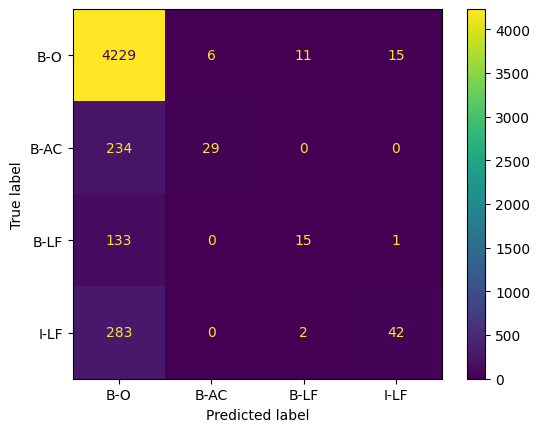

In [61]:
encoded_correct_tags = encode_tags([correct_tags], label_list)[0]
encoded_predicted = encode_tags([predicted], label_list)[0]


cm = confusion_matrix(correct_tags, predicted, labels = label_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
disp.plot() 

#### BERT evaluation

In [177]:
model = AutoModelForTokenClassification.from_pretrained("model_saves\\BERT_save", num_labels=len(label_list))
BERTtrainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [178]:
metrics = BERTtrainer.evaluate()
print(metrics)

  0%|          | 0/126 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         B-O       0.93      0.95      0.94      5197
        B-AC       0.73      0.74      0.74       563
        B-LF       0.64      0.25      0.36       290
        I-LF       0.60      0.69      0.64       487

    accuracy                           0.88      6537
   macro avg       0.73      0.66      0.67      6537
weighted avg       0.88      0.88      0.87      6537

{'eval_loss': 0.3339511752128601, 'eval_precision': 0.887690044139284, 'eval_recall': 0.8970758301668594, 'eval_f1': 0.8923582580115037, 'eval_accuracy': 0.8811381367599816, 'eval_runtime': 2.2275, 'eval_samples_per_second': 56.567, 'eval_steps_per_second': 56.567}


In [179]:
BERT_predicts = BERTtrainer.predict(tokenized_datasets["validation"])

  0%|          | 0/126 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         B-O       0.93      0.95      0.94      5197
        B-AC       0.73      0.74      0.74       563
        B-LF       0.64      0.25      0.36       290
        I-LF       0.60      0.69      0.64       487

    accuracy                           0.88      6537
   macro avg       0.73      0.66      0.67      6537
weighted avg       0.88      0.88      0.87      6537



              precision    recall  f1-score   support

         B-O       0.93      0.95      0.94      5197
        B-AC       0.73      0.74      0.74       563
        B-LF       0.64      0.25      0.36       290
        I-LF       0.60      0.69      0.64       487

    accuracy                           0.88      6537
   macro avg       0.73      0.66      0.67      6537
weighted avg       0.88      0.88      0.87      6537



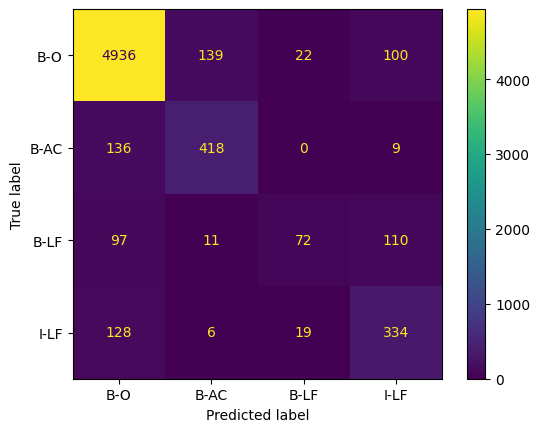

In [187]:
predictions = BERT_predicts.predictions.argmax(-1)
labels = BERT_predicts.label_ids

true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

true_predictions = [item for sublist in true_predictions for item in sublist]
labels = [item for sublist in true_labels for item in sublist]

cm = confusion_matrix(labels, true_predictions, labels=label_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
disp.plot()

# Experiment 2 (Loss Functions)
cross entropy vs MSE
This experiment is on BERT as HMM doesnt use loss functions due to its statistical nature rather than being a neural network

## Creating Custom Trainers

In [148]:
# cross entropy
class CustomBERTTrainerCrossEntropy(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = nn.CrossEntropyLoss()

    def compute_loss(self, model, inputs, return_outputs=False):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
            loss = loss*loss
            loss = loss.mean()

        return (loss, outputs) if return_outputs else loss
    
    
# MLSML
class CustomBERTTrainerMLSML(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = nn.MultiLabelSoftMarginLoss()

    def compute_loss(self, model, inputs, return_outputs=False):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
            loss = loss*loss
            loss = loss.mean()

        return (loss, outputs) if return_outputs else loss
    
    
# KLDivLoss
class CustomBERTTrainerKLDiv(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = nn.KLDivLoss()

    def compute_loss(self, model, inputs, return_outputs=False):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
            loss = loss*loss
            loss = loss.mean()

        return (loss, outputs) if return_outputs else loss
    

# MSE
class CustomBERTTrainerMSE(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = nn.MSELoss()

    def compute_loss(self, model, inputs, return_outputs=False):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
            loss = loss*loss
            loss = loss.mean()

        return (loss, outputs) if return_outputs else loss
  

In [150]:
args_CE = TrainingArguments(
    f"{model_name}-finetuned-CE-{task}",
    evaluation_strategy ='steps',
    eval_steps = 10,
    logging_steps = 10,
    save_total_limit = 1,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=1,
    num_train_epochs=5,
    weight_decay=0.001,
    save_steps=1000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=['tensorboard'],
)

args_MLSML = TrainingArguments(
    f"{model_name}-finetuned-MLSML-{task}",
    evaluation_strategy ='steps',
    eval_steps = 10,
    logging_steps = 10,
    save_total_limit = 1,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=1,
    num_train_epochs=5,
    weight_decay=0.001,
    save_steps=1000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=['tensorboard'],
)

args_KLDiv = TrainingArguments(
    f"{model_name}-finetuned-KLDiv-{task}",
    evaluation_strategy ='steps',
    eval_steps = 10,
    logging_steps = 10,
    save_total_limit = 1,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=1,
    num_train_epochs=5,
    weight_decay=0.001,
    save_steps=1000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=['tensorboard'],
)

args_MSE = TrainingArguments(
    f"{model_name}-finetuned-MSE-{task}",
    evaluation_strategy ='steps',
    eval_steps = 10,
    logging_steps = 10,
    save_total_limit = 1,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=1,
    num_train_epochs=5,
    weight_decay=0.001,
    save_steps=1000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=['tensorboard'],
)
model_CE = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
model_MLSML = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
model_KLDiv = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
model_MSE = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

BERTtrainer_CE = CustomBERTTrainerCrossEntropy(
    model_CE,
    args_CE,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_MLSML = CustomBERTTrainerMLSML(
    model_MLSML,
    args_MLSML,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_KLDiv = CustomBERTTrainerKLDiv(
    model_KLDiv,
    args_KLDiv,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_MSE = CustomBERTTrainerMSE(
    model_MSE,
    args_MSE,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initi

## Training

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
BERTtrainer_CE.train()
BERTtrainer_CE.model.save_pretrained("/kaggle/working/BERT_CE_save")
BERTtrainer_CE = None
torch.cuda.empty_cache()
gc.collect()

BERTtrainer_MLSML.train()
BERTtrainer_MLSML.model.save_pretrained("/kaggle/working/BERT_MLSML_save")
BERTtrainer_MLSML = None
torch.cuda.empty_cache()
gc.collect()

BERTtrainer_KLDiv.train()
BERTtrainer_KLDiv.model.save_pretrained("/kaggle/working/BERT_KLDiv_save")
BERTtrainer_KLDiv = None
torch.cuda.empty_cache()
gc.collect()

BERTtrainer_MSE.train()
BERTtrainer_MSE.model.save_pretrained("/kaggle/working/BERT_MSE_save")
BERTtrainer_MSE = None
torch.cuda.empty_cache()
gc.collect()

In [151]:
model_CE = AutoModelForTokenClassification.from_pretrained("model_saves/BERT_CE_save", num_labels=len(label_list))
model_MLSML = AutoModelForTokenClassification.from_pretrained("model_saves/BERT_MLSML_save", num_labels=len(label_list))
model_KLDiv = AutoModelForTokenClassification.from_pretrained("model_saves/BERT_KLDiv_save", num_labels=len(label_list))
model_MSE = AutoModelForTokenClassification.from_pretrained("model_saves/BERT_MSE_save", num_labels=len(label_list))

BERTtrainer_CE = CustomBERTTrainerCrossEntropy(
    model_CE,
    args_CE,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_MLSML = CustomBERTTrainerMLSML(
    model_MLSML,
    args_MLSML,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_KLDiv = CustomBERTTrainerKLDiv(
    model_KLDiv,
    args_KLDiv,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_MSE = CustomBERTTrainerMSE(
    model_MSE,
    args_MSE,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

## Evaluation

In [152]:
CE_eval = BERTtrainer_CE.evaluate()
print(CE_eval)
MLSML_eval = BERTtrainer_MLSML.evaluate()
print(MLSML_eval)
KLDiv_eval = BERTtrainer_KLDiv.evaluate()
print(KLDiv_eval)
MSE_eval = BERTtrainer_MSE.evaluate()
print(MSE_eval)

  0%|          | 0/126 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         B-O       0.96      0.95      0.96      5197
        B-AC       0.81      0.85      0.83       563
        B-LF       0.75      0.71      0.73       290
        I-LF       0.75      0.85      0.80       487

    accuracy                           0.92      6537
   macro avg       0.82      0.84      0.83      6537
weighted avg       0.93      0.92      0.92      6537

{'eval_loss': 0.11299525201320648, 'eval_precision': 0.9310058187863675, 'eval_recall': 0.9251610771518255, 'eval_f1': 0.9280742459396751, 'eval_accuracy': 0.9229004130335016, 'eval_runtime': 2.2405, 'eval_samples_per_second': 56.237, 'eval_steps_per_second': 56.237}


  0%|          | 0/126 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         B-O       0.96      0.95      0.96      5197
        B-AC       0.81      0.84      0.82       563
        B-LF       0.73      0.76      0.74       290
        I-LF       0.77      0.84      0.80       487

    accuracy                           0.92      6537
   macro avg       0.82      0.85      0.83      6537
weighted avg       0.93      0.92      0.92      6537

{'eval_loss': 0.10830678045749664, 'eval_precision': 0.93033670592138, 'eval_recall': 0.9266479431686767, 'eval_f1': 0.9284886608177454, 'eval_accuracy': 0.9229004130335016, 'eval_runtime': 2.3795, 'eval_samples_per_second': 52.951, 'eval_steps_per_second': 52.951}


  0%|          | 0/126 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         B-O       0.97      0.94      0.95      5197
        B-AC       0.78      0.85      0.81       563
        B-LF       0.72      0.75      0.74       290
        I-LF       0.76      0.85      0.80       487

    accuracy                           0.92      6537
   macro avg       0.81      0.85      0.83      6537
weighted avg       0.92      0.92      0.92      6537

{'eval_loss': 0.11526535451412201, 'eval_precision': 0.9276567437219359, 'eval_recall': 0.9215265157773005, 'eval_f1': 0.9245814685894249, 'eval_accuracy': 0.9196879302432308, 'eval_runtime': 3.9611, 'eval_samples_per_second': 31.81, 'eval_steps_per_second': 31.81}


  0%|          | 0/126 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5197
        B-AC       0.81      0.85      0.83       563
        B-LF       0.76      0.74      0.75       290
        I-LF       0.77      0.86      0.81       487

    accuracy                           0.93      6537
   macro avg       0.83      0.85      0.84      6537
weighted avg       0.93      0.93      0.93      6537

{'eval_loss': 0.1157521978020668, 'eval_precision': 0.9345514950166113, 'eval_recall': 0.9294564678671733, 'eval_f1': 0.9319970181396504, 'eval_accuracy': 0.9267247973076335, 'eval_runtime': 2.3528, 'eval_samples_per_second': 53.554, 'eval_steps_per_second': 53.554}


# Experiment 3 (Additional Training Samples from Optional Dataset)

lemmatization with Bag of Words VS Word2Vec

## Collecting Dataset

In [189]:
filtered_dataset = load_dataset("surrey-nlp/PLOD-filtered")

In [190]:
filtered_train = filtered_dataset["train"]
print(f"train size: {len(filtered_train)}")
filtered_val = filtered_dataset["validation"]
print(f"val size: {len(filtered_val)}")
filtered_test = filtered_dataset["test"]
print(f"test size: {len(filtered_test)}")

train size: 112652
val size: 24140
test size: 24140


## Extracting Data to Use
I will have three tests, using three sizes of data acquired from the filtered dataset.

small: 1072 extra samples to double the dataset size  
medium: 10000 extra samples  
large: 50000 extra samples

In [191]:
def decode_tags(tag_sequences, possible_tags):
    """
    Decodes a sequence of numerical tags into a list of corresponding textual labels.

    Args:
        tag_sequence: A list of integers representing numerical tags.
        possible_tags: A list of strings representing the possible textual labels.

    Returns:
        A list of strings representing the decoded textual tags.
    """

    decoded_tags = [[possible_tags[tag] for tag in row] for row in tag_sequences]
    return decoded_tags


def build_dataset(filtered_set, cw_set, num_of_samples):
    """
    Merges a specified number of rows from a larger list to a smaller list, ensuring no duplicates.

    Args:
        filtered_set: a split of the filtered dataset
        cw_set: a split of the cw dataset
        num_of_samples: The number of rows to add from the filtered set.

    Returns:
        new tokens, pos_tags and ner_tags lists
    """
    # set up the initial lists
    tokens = cw_set["tokens"]
    pos_tags = cw_set["pos_tags"]
    ner_tags = cw_set["ner_tags"]
     
    # set up the filtered lists
    # tokens
    filtered_tokens = filtered_set["tokens"]
    # pos_tags
    filtered_label_list = filtered_set.features[f"pos_tags"].feature.names
    filtered_pos_tags = decode_tags(filtered_set["pos_tags"], filtered_label_list)
    # ner_tags
    filtered_label_list = filtered_set.features[f"ner_tags"].feature.names
    filtered_ner_tags = decode_tags(filtered_set["ner_tags"], filtered_label_list)

    # convert the tokens list to sets for efficient duplicate checking
    tokens_set = set(tuple(row) for row in tokens)
    filtered_tokens_set = set(tuple(row) for row in filtered_tokens)

    # find rows to add
    rows_to_add = []
    for index, row in enumerate(filtered_tokens_set):
        if tuple(row) not in tokens_set and len(rows_to_add) < num_of_samples:
            rows_to_add.append(index)

    # Merge and return the lists
    tokens = tokens + [filtered_tokens[i] for i in rows_to_add]
    pos_tags = pos_tags + [filtered_pos_tags[i] for i in rows_to_add]
    ner_tags = ner_tags + [filtered_ner_tags[i] for i in rows_to_add]

    return tokens, pos_tags, ner_tags




In [192]:
small = 1072
medium = 10000
large = 50000
tokens_small, pos_tags_small, ner_tags_small = build_dataset(filtered_train, train, small)
tokens_small = pre_process_data(tokens_small, pos_tags_small)
tokens_medium, pos_tags_medium, ner_tags_medium = build_dataset(filtered_train, train, medium)
tokens_medium = pre_process_data(tokens_medium, pos_tags_medium)
tokens_large, pos_tags_large, ner_tags_large = build_dataset(filtered_train, train, large)
tokens_large = pre_process_data(tokens_large, pos_tags_large)
print(f"num of small samples: {len(tokens_small)}\nnum of medium samples: {len(tokens_medium)}\nnum of large samples: {len(tokens_large)}")

num of small samples: 2144
num of medium samples: 11072
num of large samples: 51072


## Training

### HMM Training

In [ ]:
# create the character sets
char_set_small = get_char_set(tokens_small)
char_set_medium = get_char_set(tokens_medium)
char_set_large = get_char_set(tokens_large)

# create trainers
#small
trainer_small = nltk.tag.hmm.HiddenMarkovModelTrainer(states=label_list, symbols=char_set_small)
data_small = combine_lists_elementwise(tokens_small.copy(), ner_tags_small.copy())
# medium
trainer_medium = nltk.tag.hmm.HiddenMarkovModelTrainer(states=label_list, symbols=char_set_medium)
data_medium = combine_lists_elementwise(tokens_medium.copy(), ner_tags_medium.copy())
# large
trainer_large = nltk.tag.hmm.HiddenMarkovModelTrainer(states=label_list, symbols=char_set_large)
data_large = combine_lists_elementwise(tokens_large.copy(), ner_tags_large.copy())

In [ ]:
model_small = trainer_small.train_supervised(data_small)
model_medium = trainer_medium.train_supervised(data_medium)
model_large = trainer_large.train_supervised(data_large)

In [ ]:
save_hmm(model_small, "hmm_model_small.dill")
save_hmm(model_medium, "hmm_model_medium.dill")
save_hmm(model_large, "hmm_model_large.dill")

In [193]:
model_small = load_hmm("hmm_model_small.dill")
model_medium = load_hmm("hmm_model_medium.dill")
model_large = load_hmm("hmm_model_large.dill")

Model loaded successfully!
Model loaded successfully!
Model loaded successfully!


### BERT Training

In [203]:
# create 3 datasets

small_datasets_dict = {
    "train": Dataset.from_dict({"tokens": tokens_small, "pos_tags": pos_tags_small, "ner_tags": ner_tags_small})
}
medium_datasets_dict = {
    "train": Dataset.from_dict({"tokens": tokens_medium, "pos_tags": pos_tags_medium, "ner_tags": ner_tags_medium})
}
large_datasets_dict = {
    "train": Dataset.from_dict({"tokens": tokens_large, "pos_tags": pos_tags_large, "ner_tags": ner_tags_large})
}

small_dataset = DatasetDict(small_datasets_dict)
medium_dataset = DatasetDict(medium_datasets_dict)
large_dataset = DatasetDict(large_datasets_dict)

In [204]:
small_tokenized_dataset = small_dataset.map(tokenize_and_align_labels, batched=True)
medium_tokenized_dataset = medium_dataset.map(tokenize_and_align_labels, batched=True)
large_tokenized_dataset = large_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/2144 [00:00<?, ? examples/s]

Map:   0%|          | 0/11072 [00:00<?, ? examples/s]

Map:   0%|          | 0/51072 [00:00<?, ? examples/s]

In [205]:
args_small = TrainingArguments(
    f"{model_name}-finetuned-small-{task}",
    evaluation_strategy ='steps',
    eval_steps = 20,
    logging_steps = 20,
    save_total_limit = 1,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.001,
    save_steps=0,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=["tensorboard"],
)
args_medium = TrainingArguments(
    f"{model_name}-finetuned-medium-{task}",
    evaluation_strategy ='steps',
    eval_steps = 50,
    logging_steps = 50,
    save_total_limit = 1,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.001,
    save_steps=0,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=["tensorboard"],
)
args_large = TrainingArguments(
    f"{model_name}-finetuned-large-{task}",
    evaluation_strategy ='steps',
    eval_steps = 300,
    logging_steps = 300,
    save_total_limit = 1,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.001,
    save_steps=0,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=["tensorboard"],
)

model_small = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
model_medium = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
model_large = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))


BERTtrainer_small = Trainer(
    model_small,
    args_small,
    train_dataset=small_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_medium = Trainer(
    model_medium,
    args_medium,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_large = Trainer(
    model_large,
    args_large,
    train_dataset=large_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# BERTtrainer_small = None
# BERTtrainer_medium = None
# BERTtrainer_large = None
# BERTtrainer = None
torch.cuda.empty_cache()
gc.collect()

In [ ]:
BERTtrainer_small.train()
BERTtrainer_small.model.save_pretrained("/kaggle/working/BERT_small_save")
BERTtrainer_small = None
torch.cuda.empty_cache()
gc.collect()

BERTtrainer_medium.train()
BERTtrainer_medium.model.save_pretrained("/kaggle/working/BERT_medium_save")
BERTtrainer_medium = None
torch.cuda.empty_cache()
gc.collect()

gc.collect()
torch.cuda.empty_cache()
BERTtrainer_large.train()
BERTtrainer_large.model.save_pretrained("/kaggle/working/BERT_large_save")
BERTtrainer_large = None
torch.cuda.empty_cache()
gc.collect()

## evaluation

### HMM Evaluation

In [194]:
model_small = load_hmm("hmm_model_small.dill")
model_medium = load_hmm("hmm_model_medium.dill")
model_large = load_hmm("hmm_model_large.dill")

Model loaded successfully!
Model loaded successfully!
Model loaded successfully!


In [195]:
predicted_small = evaluate_hmm(model_small, test_sentences)
predicted_medium = evaluate_hmm(model_medium, test_sentences)
predicted_large = evaluate_hmm(model_large, test_sentences)

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\tag\hmm.py:336: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\tag\hmm.py:334: RuntimeWarning: overflow encountered in cast
  X[i, j] = self._transitions[si].logprob(self._states[j])
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\tag\hmm.py:332: RuntimeWarning: overflow encountered in cast
  P[i] = self._priors.logprob(si)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\tag\hmm.py:364: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob

In [196]:
predicted_small = [item for sublist in predicted_small for item in sublist]
predicted_medium = [item for sublist in predicted_medium for item in sublist]
predicted_large = [item for sublist in predicted_large for item in sublist]

print(len(correct_tags))
print(len(predicted_small))
print(len(predicted_medium))
print(len(predicted_large))


5000
5000
5000
5000


In [197]:
print(classification_report(correct_tags, predicted_small, labels = label_list))
print(classification_report(correct_tags, predicted_medium, labels = label_list))
print(classification_report(correct_tags, predicted_large, labels = label_list))

              precision    recall  f1-score   support

         B-O       0.87      0.98      0.92      4261
        B-AC       0.84      0.18      0.29       263
        B-LF       0.51      0.15      0.24       149
        I-LF       0.58      0.16      0.25       327

    accuracy                           0.86      5000
   macro avg       0.70      0.37      0.43      5000
weighted avg       0.84      0.86      0.83      5000

              precision    recall  f1-score   support

         B-O       0.90      0.97      0.94      4261
        B-AC       0.86      0.37      0.51       263
        B-LF       0.57      0.32      0.41       149
        I-LF       0.65      0.39      0.49       327

    accuracy                           0.88      5000
   macro avg       0.74      0.51      0.58      5000
weighted avg       0.87      0.88      0.87      5000

              precision    recall  f1-score   support

         B-O       0.94      0.97      0.96      4261
        B-AC       0.

#### Calculate MCC

In [201]:
print(matthews_corrcoef(correct_tags, predicted_small))
print(matthews_corrcoef(correct_tags, predicted_medium))
print(matthews_corrcoef(correct_tags, predicted_large))

0.29521559592637375
0.4727518631532203
0.681932947075382


### BERT Evaluation

In [206]:
model_small = AutoModelForTokenClassification.from_pretrained("model_saves/BERT_small_save", num_labels=len(label_list))
model_medium = AutoModelForTokenClassification.from_pretrained("model_saves/BERT_medium_save", num_labels=len(label_list))
model_large = AutoModelForTokenClassification.from_pretrained("model_saves/BERT_large_save", num_labels=len(label_list))


BERTtrainer_small = Trainer(
    model_small,
    args_small,
    train_dataset=small_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_medium = Trainer(
    model_medium,
    args_medium,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_large = Trainer(
    model_large,
    args_large,
    train_dataset=large_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# BERTtrainer_small.model.from_pretrained("model_saves/BERT_small_save")
# BERTtrainer_medium.model.from_pretrained("model_saves/BERT_medium_save")
# BERTtrainer_large.model.from_pretrained("model_saves/BERT_large_save")

small_metrics = BERTtrainer_small.evaluate()
print(small_metrics)
medium_metrics = BERTtrainer_medium.evaluate()
print(medium_metrics)
large_metrics = BERTtrainer_large.evaluate()
print(large_metrics)

  0%|          | 0/126 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         B-O       0.96      0.94      0.95      5197
        B-AC       0.74      0.82      0.78       563
        B-LF       0.66      0.66      0.66       290
        I-LF       0.72      0.83      0.77       487

    accuracy                           0.91      6537
   macro avg       0.77      0.81      0.79      6537
weighted avg       0.91      0.91      0.91      6537

{'eval_loss': 0.26455628871917725, 'eval_precision': 0.9140572951365756, 'eval_recall': 0.906657855608789, 'eval_f1': 0.9103425396035498, 'eval_accuracy': 0.9062260975982867, 'eval_runtime': 2.3886, 'eval_samples_per_second': 52.751, 'eval_steps_per_second': 52.751}


  0%|          | 0/126 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5197
        B-AC       0.82      0.87      0.84       563
        B-LF       0.76      0.83      0.79       290
        I-LF       0.78      0.89      0.83       487

    accuracy                           0.93      6537
   macro avg       0.83      0.88      0.86      6537
weighted avg       0.94      0.93      0.93      6537

{'eval_loss': 0.1811598688364029, 'eval_precision': 0.9424904150691782, 'eval_recall': 0.9340822732529325, 'eval_f1': 0.9382675074676402, 'eval_accuracy': 0.933149762888175, 'eval_runtime': 2.3391, 'eval_samples_per_second': 53.866, 'eval_steps_per_second': 53.866}


  0%|          | 0/126 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         B-O       0.98      0.96      0.97      5197
        B-AC       0.88      0.90      0.89       563
        B-LF       0.78      0.87      0.82       290
        I-LF       0.80      0.92      0.86       487

    accuracy                           0.94      6537
   macro avg       0.86      0.91      0.88      6537
weighted avg       0.95      0.94      0.95      6537

{'eval_loss': 0.1521802544593811, 'eval_precision': 0.9544924154025671, 'eval_recall': 0.9459772013877417, 'eval_f1': 0.9502157318287422, 'eval_accuracy': 0.9444699403396053, 'eval_runtime': 2.2633, 'eval_samples_per_second': 55.671, 'eval_steps_per_second': 55.671}


#### Calculate MCC

In [208]:
small_predictions = BERTtrainer_small.predict(tokenized_datasets["validation"])
medium_predictions = BERTtrainer_medium.predict(tokenized_datasets["validation"])
large_predictions = BERTtrainer_large.predict(tokenized_datasets["validation"])

labels = small_predictions.label_ids

small_predictions = small_predictions.predictions.argmax(-1)
medium_predictions = medium_predictions.predictions.argmax(-1)
large_predictions = large_predictions.predictions.argmax(-1)


true_predictions_small = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(small_predictions, labels)
    ]
true_predictions_medium = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(medium_predictions, labels)
    ]
true_predictions_large = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(large_predictions, labels)
    ]


true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(small_predictions, labels)
    ]

true_predictions_small = [item for sublist in true_predictions_small for item in sublist]
true_predictions_medium = [item for sublist in true_predictions_medium for item in sublist]
true_predictions_large = [item for sublist in true_predictions_large for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]


print(matthews_corrcoef(true_labels, true_predictions_small))
print(matthews_corrcoef(true_labels, true_predictions_medium))
print(matthews_corrcoef(true_labels, true_predictions_large))

  0%|          | 0/126 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         B-O       0.96      0.94      0.95      5197
        B-AC       0.74      0.82      0.78       563
        B-LF       0.66      0.66      0.66       290
        I-LF       0.72      0.83      0.77       487

    accuracy                           0.91      6537
   macro avg       0.77      0.81      0.79      6537
weighted avg       0.91      0.91      0.91      6537



  0%|          | 0/126 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5197
        B-AC       0.82      0.87      0.84       563
        B-LF       0.76      0.83      0.79       290
        I-LF       0.78      0.89      0.83       487

    accuracy                           0.93      6537
   macro avg       0.83      0.88      0.86      6537
weighted avg       0.94      0.93      0.93      6537



  0%|          | 0/126 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         B-O       0.98      0.96      0.97      5197
        B-AC       0.88      0.90      0.89       563
        B-LF       0.78      0.87      0.82       290
        I-LF       0.80      0.92      0.86       487

    accuracy                           0.94      6537
   macro avg       0.86      0.91      0.88      6537
weighted avg       0.95      0.94      0.95      6537

0.7459767729923106
0.8192710779366021
0.8490004655748122


# Experiment 4 (Hyperparameters)

## Arguments For Each Test

In [ ]:
args_one = TrainingArguments(
    f"{model_name}-finetuned-one-{task}",
    evaluation_strategy ='steps',
    eval_steps = 100,
    logging_steps = 100,
    save_total_limit = 1,
    learning_rate=0.01,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    max_grad_norm=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.001,
    save_steps=0,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=["tensorboard"],
)

args_two = TrainingArguments(
    f"{model_name}-finetuned-two-{task}",
    evaluation_strategy ='steps',
    eval_steps = 100,
    logging_steps = 100,
    save_total_limit = 1,
    learning_rate=0.001,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    max_grad_norm=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.001,
    save_steps=0,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=["tensorboard"],
)

args_three = TrainingArguments(
    f"{model_name}-finetuned-three-{task}",
    evaluation_strategy ='steps',
    eval_steps = 100,
    logging_steps = 100,
    save_total_limit = 1,
    learning_rate=0.0001,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    max_grad_norm=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.001,
    save_steps=0,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=["tensorboard"],
)

args_four = TrainingArguments(
    f"{model_name}-finetuned-four-{task}",
    evaluation_strategy ='steps',
    eval_steps = 100,
    logging_steps = 100,
    save_total_limit = 1,
    learning_rate=0.00001,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    max_grad_norm=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.001,
    save_steps=0,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=["tensorboard"],
)


args_five = TrainingArguments(
    f"{model_name}-finetuned-five-{task}",
    evaluation_strategy ='steps',
    eval_steps = 100,
    logging_steps = 100,
    save_total_limit = 1,
    learning_rate=0.000001,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    max_grad_norm=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.001,
    save_steps=0,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=["tensorboard"],
)

args_six = TrainingArguments(
    f"{model_name}-finetuned-six-{task}",
    evaluation_strategy ='steps',
    eval_steps = 100,
    logging_steps = 100,
    save_total_limit = 1,
    learning_rate=0.00001,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    max_grad_norm=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=1,
    num_train_epochs=5,
    weight_decay=0.001,
    save_steps=0,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=["tensorboard"],
)

args_seven = TrainingArguments(
    f"{model_name}-finetuned-seven-{task}",
    evaluation_strategy ='steps',
    eval_steps = 100,
    logging_steps = 100,
    save_total_limit = 1,
    learning_rate=0.00001,
    adam_beta1=0.5,
    adam_beta2=0.5,
    adam_epsilon=1e-8,
    max_grad_norm=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    weight_decay=0.001,
    save_steps=0,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=["tensorboard"],
)

args_eight = TrainingArguments(
    f"{model_name}-finetuned-eight-{task}",
    evaluation_strategy ='steps',
    eval_steps = 100,
    logging_steps = 100,
    save_total_limit = 1,
    learning_rate=0.00001,
    adam_beta1=0.2,
    adam_beta2=0.2,
    adam_epsilon=1e-8,
    max_grad_norm=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    weight_decay=0.001,
    save_steps=0,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=["tensorboard"],
)

args_nine = TrainingArguments(
    f"{model_name}-finetuned-nine-{task}",
    evaluation_strategy ='steps',
    eval_steps = 100,
    logging_steps = 100,
    save_total_limit = 1,
    learning_rate=0.00001,
    adam_beta1=0.1,
    adam_beta2=0.9,
    adam_epsilon=1e-8,
    max_grad_norm=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    weight_decay=0.001,
    save_steps=0,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=["tensorboard"],
)


args_ten = TrainingArguments(
    f"{model_name}-finetuned-ten-{task}",
    evaluation_strategy ='steps',
    eval_steps = 100,
    logging_steps = 100,
    save_total_limit = 1,
    learning_rate=0.00001,
    adam_beta1=0.9,
    adam_beta2=0.1,
    adam_epsilon=1e-8,
    max_grad_norm=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=1,
    num_train_epochs=5,
    weight_decay=0.001,
    save_steps=0,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to=["tensorboard"],
)

In [ ]:
model_ex_4 = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

## Training

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
BERTtrainer_ex_4 = Trainer(
    model_ex_4,
    args_one,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_ex_4.train()
BERTtrainer_ex_4.model.save_pretrained("model_saves/BERT_ex4_one_save")
BERTtrainer_ex_4 = None
torch.cuda.empty_cache()
gc.collect()

model_ex_4 = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
BERTtrainer_ex_4 = Trainer(
    model_ex_4,
    args_two,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_ex_4.train()
BERTtrainer_ex_4.model.save_pretrained("model_saves/BERT_ex4_two_save")
BERTtrainer_ex_4 = None
torch.cuda.empty_cache()
gc.collect()

model_ex_4 = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
BERTtrainer_ex_4 = Trainer(
    model_ex_4,
    args_four,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_ex_4.train()
BERTtrainer_ex_4.model.save_pretrained("model_saves/BERT_ex4_four_save")
BERTtrainer_ex_4 = None
torch.cuda.empty_cache()
gc.collect()


model_ex_4 = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
BERTtrainer_ex_4 = Trainer(
    model_ex_4,
    args_five,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_ex_4.train()
BERTtrainer_ex_4.model.save_pretrained("model_saves/BERT_ex4_five_save")
BERTtrainer_ex_4 = None
torch.cuda.empty_cache()
gc.collect()

model_ex_4 = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
BERTtrainer_ex_4 = Trainer(
    model_ex_4,
    args_seven,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_ex_4.train()
BERTtrainer_ex_4.model.save_pretrained("model_saves/BERT_ex4_seven_save")
BERTtrainer_ex_4 = None
torch.cuda.empty_cache()
gc.collect()

model_ex_4 = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
BERTtrainer_ex_4 = Trainer(
    model_ex_4,
    args_eight,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_ex_4.train()
BERTtrainer_ex_4.model.save_pretrained("model_saves/BERT_ex4_eight_save")
BERTtrainer_ex_4 = None
torch.cuda.empty_cache()
gc.collect()

model_ex_4 = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
BERTtrainer_ex_4 = Trainer(
    model_ex_4,
    args_nine,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_ex_4.train()
BERTtrainer_ex_4.model.save_pretrained("model_saves/BERT_ex4_nine_save")
BERTtrainer_ex_4 = None
torch.cuda.empty_cache()
gc.collect()

model_ex_4 = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
BERTtrainer_ex_4 = Trainer(
    model_ex_4,
    args_ten,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_ex_4.train()
BERTtrainer_ex_4.model.save_pretrained("model_saves/BERT_ex4_ten_save")
BERTtrainer_ex_4 = None
torch.cuda.empty_cache()
gc.collect()

## Evaluation

In [ ]:
model_ex_4_one = AutoModelForTokenClassification.from_pretrained("model_saves/BERT_ex4_one_save", num_labels=len(label_list))
model_ex_4_two = AutoModelForTokenClassification.from_pretrained("model_saves/BERT_ex4_two_save", num_labels=len(label_list))
model_ex_4_three = AutoModelForTokenClassification.from_pretrained("model_saves/BERT_ex4_three_save", num_labels=len(label_list))
model_ex_4_four = AutoModelForTokenClassification.from_pretrained("model_saves/BERT_ex4_four_save", num_labels=len(label_list))
model_ex_4_five = AutoModelForTokenClassification.from_pretrained("model_saves/BERT_ex4_five_save", num_labels=len(label_list))
model_ex_4_six = AutoModelForTokenClassification.from_pretrained("model_saves/BERT_ex4_six_save", num_labels=len(label_list))
model_ex_4_seven = AutoModelForTokenClassification.from_pretrained("model_saves/BERT_ex4_seven_save", num_labels=len(label_list))
model_ex_4_eight = AutoModelForTokenClassification.from_pretrained("model_saves/BERT_ex4_eight_save", num_labels=len(label_list))
model_ex_4_nine = AutoModelForTokenClassification.from_pretrained("model_saves/BERT_ex4_nine_save", num_labels=len(label_list))
model_ex_4_ten = AutoModelForTokenClassification.from_pretrained("model_saves/BERT_ex4_ten_save", num_labels=len(label_list))

BERTtrainer_ex_4_one = Trainer(
    model_ex_4_one,
    args_one,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_ex_4_two = Trainer(
    model_ex_4_two,
    args_two,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_ex_4_three = Trainer(
    model_ex_4_three,
    args_three,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_ex_4_four = Trainer(
    model_ex_4_four,
    args_four,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_ex_4_five = Trainer(
    model_ex_4_five,
    args_five,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_ex_4_six = Trainer(
    model_ex_4_six,
    args_six,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_ex_4_seven = Trainer(
    model_ex_4_seven,
    args_seven,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_ex_4_eight = Trainer(
    model_ex_4_eight,
    args_eight,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_ex_4_nine = Trainer(
    model_ex_4_nine,
    args_nine,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BERTtrainer_ex_4_ten = Trainer(
    model_ex_4_ten,
    args_ten,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


In [ ]:
metrics = BERTtrainer_ex_4_one.evaluate()
print(metrics)

In [ ]:
metrics = BERTtrainer_ex_4_two.evaluate()
print(metrics)



In [ ]:
metrics = BERTtrainer_ex_4_three.evaluate()
print(metrics)



In [ ]:
metrics = BERTtrainer_ex_4_four.evaluate()
print(metrics)



In [ ]:
metrics = BERTtrainer_ex_4_five.evaluate()
print(metrics)



In [ ]:
metrics = BERTtrainer_ex_4_six.evaluate()
print(metrics)



In [ ]:
metrics = BERTtrainer_ex_4_seven.evaluate()
print(metrics)



In [ ]:
metrics = BERTtrainer_ex_4_eight.evaluate()
print(metrics)



In [ ]:
metrics = BERTtrainer_ex_4_nine.evaluate()
print(metrics)



In [ ]:
metrics = BERTtrainer_ex_4_ten.evaluate()
print(metrics)

## Automatic Hyperparameter Tuning

In [31]:
model_name = "bert-base-uncased"

In [32]:
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 3e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16]),
        "num_train_epochs": trial.suggest_int("epochs", 1, 3),
        "weight_decay": trial.suggest_float("weight_decay", 0.0005, 0.01),
        "adam_beta1": trial.suggest_float("adam_beta1", 0.1, 0.9),
        "adam_beta2": trial.suggest_float("adam_beta2", 0.1, 0.9)
}

In [34]:
def model_init(trial):
    return BertForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))

In [35]:
train_args = TrainingArguments(
        f"{model_name}-finetuned-optuna-{task}",
        evaluation_strategy ='steps',
        # eval_steps = 10,
        # logging_steps = 10,
        save_total_limit = 1, 
        adam_epsilon=1e-8,
        max_grad_norm=1,
        per_device_eval_batch_size=1,
        save_steps=0,
        metric_for_best_model = 'f1',
        load_best_model_at_end=True,
        report_to=["none"],
    )

In [36]:
trainer = Trainer(
    model=None,
    args=train_args,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    model_init=model_init,
    data_collator=data_collator,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
torch.cuda.empty_cache()
gc.collect()

61

In [39]:
def custom_objective(eval_result):
  f1 = eval_result["eval_f1"]
  loss = eval_result["eval_loss"]
  return f1, loss


In [40]:
best_trials = trainer.hyperparameter_search(
    direction=["maximize", "minimize"],
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=20,
    compute_objective=custom_objective,
)

[I 2024-04-22 11:18:25,569] A new study created in memory with name: no-name-f8da4f76-b586-4596-bed1-44bddb9646ce
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.309600,0.197858,0.940979,0.927144,0.934010,0.928255
1000,0.228400,0.185127,0.945914,0.933256,0.939543,0.933915
1500,0.203900,0.173009,0.947719,0.940360,0.944025,0.938810
2000,0.175700,0.167916,0.949784,0.943664,0.946714,0.940952
2500,0.183600,0.164975,0.949119,0.943003,0.946051,0.940187
3000,0.167600,0.171188,0.949900,0.942838,0.946356,0.940187
3500,0.159200,0.164691,0.947953,0.944821,0.946384,0.941410
4000,0.152300,0.165060,0.950100,0.943664,0.946871,0.940799


              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5197
        B-AC       0.82      0.85      0.83       563
        B-LF       0.76      0.77      0.76       290
        I-LF       0.74      0.91      0.82       487

    accuracy                           0.93      6537
   macro avg       0.82      0.87      0.84      6537
weighted avg       0.93      0.93      0.93      6537

              precision    recall  f1-score   support

         B-O       0.98      0.94      0.96      5197
        B-AC       0.82      0.90      0.86       563
        B-LF       0.76      0.82      0.79       290
        I-LF       0.76      0.92      0.83       487

    accuracy                           0.93      6537
   macro avg       0.83      0.90      0.86      6537
weighted avg       0.94      0.93      0.94      6537

              precision    recall  f1-score   support

         B-O       0.97      0.96      0.97      5197
        B-AC       0.

[I 2024-04-22 11:27:54,487] Trial 0 finished with values: [0.9468711147948612, 0.16505979001522064] and parameters: {'learning_rate': 1.4862333383535989e-05, 'per_device_train_batch_size': 8, 'epochs': 3, 'weight_decay': 0.007632839440960023, 'adam_beta1': 0.2374782514693039, 'adam_beta2': 0.6740412716573023}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.318600,0.211133,0.929394,0.932926,0.931157,0.925501
1000,0.236600,0.190024,0.946470,0.934743,0.940570,0.933915
1500,0.222600,0.193186,0.940199,0.935074,0.937629,0.932385
2000,0.216300,0.199294,0.945787,0.930943,0.938307,0.931467
2500,0.198000,0.170724,0.949141,0.940360,0.944730,0.938351
3000,0.190200,0.183322,0.948633,0.945812,0.947220,0.940799
3500,0.158300,0.182057,0.948957,0.939865,0.944389,0.938351
4000,0.165800,0.178504,0.949161,0.943830,0.946488,0.940034
4500,0.171800,0.182520,0.948880,0.944490,0.946680,0.940646
5000,0.163600,0.180918,0.950964,0.945151,0.948049,0.941869


              precision    recall  f1-score   support

         B-O       0.95      0.96      0.96      5197
        B-AC       0.88      0.75      0.81       563
        B-LF       0.71      0.81      0.76       290
        I-LF       0.82      0.80      0.81       487

    accuracy                           0.93      6537
   macro avg       0.84      0.83      0.83      6537
weighted avg       0.93      0.93      0.93      6537

              precision    recall  f1-score   support

         B-O       0.97      0.96      0.96      5197
        B-AC       0.87      0.83      0.85       563
        B-LF       0.76      0.76      0.76       290
        I-LF       0.76      0.90      0.83       487

    accuracy                           0.93      6537
   macro avg       0.84      0.86      0.85      6537
weighted avg       0.94      0.93      0.93      6537

              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5197
        B-AC       0.

[I 2024-04-22 11:35:08,182] Trial 1 finished with values: [0.9474643685780577, 0.1775275617837906] and parameters: {'learning_rate': 1.5201145492997306e-05, 'per_device_train_batch_size': 4, 'epochs': 2, 'weight_decay': 0.0013132813377010506, 'adam_beta1': 0.34055734532514564, 'adam_beta2': 0.10271393282928454}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.296500,0.201248,0.939069,0.926813,0.932901,0.928102
1000,0.205400,0.170630,0.945137,0.939204,0.942161,0.936515


              precision    recall  f1-score   support

         B-O       0.98      0.94      0.96      5197
        B-AC       0.78      0.90      0.84       563
        B-LF       0.75      0.80      0.78       290
        I-LF       0.75      0.91      0.82       487

    accuracy                           0.93      6537
   macro avg       0.82      0.89      0.85      6537
weighted avg       0.94      0.93      0.93      6537

              precision    recall  f1-score   support

         B-O       0.97      0.96      0.96      5197
        B-AC       0.86      0.86      0.86       563
        B-LF       0.77      0.81      0.79       290
        I-LF       0.79      0.87      0.83       487

    accuracy                           0.94      6537
   macro avg       0.85      0.88      0.86      6537
weighted avg       0.94      0.94      0.94      6537



[I 2024-04-22 11:41:43,796] Trial 2 finished with values: [0.9421610871726881, 0.17062970995903015] and parameters: {'learning_rate': 1.4225203287307486e-05, 'per_device_train_batch_size': 16, 'epochs': 2, 'weight_decay': 0.009441913650384852, 'adam_beta1': 0.1007033905579739, 'adam_beta2': 0.10660561316440083}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.322400,0.204400,0.938735,0.926483,0.932568,0.925807
1000,0.234100,0.189254,0.940902,0.931109,0.935979,0.930855


              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5197
        B-AC       0.81      0.85      0.83       563
        B-LF       0.74      0.75      0.75       290
        I-LF       0.74      0.90      0.81       487

    accuracy                           0.93      6537
   macro avg       0.82      0.86      0.84      6537
weighted avg       0.93      0.93      0.93      6537

              precision    recall  f1-score   support

         B-O       0.98      0.95      0.96      5197
        B-AC       0.80      0.89      0.84       563
        B-LF       0.75      0.80      0.78       290
        I-LF       0.77      0.90      0.83       487

    accuracy                           0.93      6537
   macro avg       0.82      0.88      0.85      6537
weighted avg       0.94      0.93      0.93      6537



[I 2024-04-22 11:44:55,014] Trial 3 finished with values: [0.9359794071244706, 0.18925434350967407] and parameters: {'learning_rate': 1.1666504209998573e-05, 'per_device_train_batch_size': 8, 'epochs': 1, 'weight_decay': 0.009348845981118455, 'adam_beta1': 0.46219664966634755, 'adam_beta2': 0.7363835231366819}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.317400,0.201056,0.932945,0.926318,0.929619,0.925807


              precision    recall  f1-score   support

         B-O       0.97      0.94      0.96      5197
        B-AC       0.79      0.87      0.83       563
        B-LF       0.72      0.79      0.76       290
        I-LF       0.77      0.87      0.82       487

    accuracy                           0.93      6537
   macro avg       0.81      0.87      0.84      6537
weighted avg       0.93      0.93      0.93      6537



[I 2024-04-22 11:48:13,086] Trial 4 finished with values: [0.9296194976374036, 0.20105579495429993] and parameters: {'learning_rate': 1.0495334892765539e-05, 'per_device_train_batch_size': 16, 'epochs': 1, 'weight_decay': 0.004177094768599791, 'adam_beta1': 0.5947944115007203, 'adam_beta2': 0.7119370854788608}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.306500,0.192577,0.940393,0.933091,0.936728,0.932538
1000,0.205500,0.169847,0.946440,0.940030,0.943224,0.937739
1500,0.194200,0.175756,0.947263,0.937717,0.942466,0.938045
2000,0.178100,0.169647,0.948097,0.938543,0.943296,0.938351


              precision    recall  f1-score   support

         B-O       0.98      0.95      0.96      5197
        B-AC       0.80      0.90      0.85       563
        B-LF       0.76      0.82      0.79       290
        I-LF       0.78      0.89      0.83       487

    accuracy                           0.93      6537
   macro avg       0.83      0.89      0.86      6537
weighted avg       0.94      0.93      0.93      6537

              precision    recall  f1-score   support

         B-O       0.97      0.96      0.97      5197
        B-AC       0.85      0.87      0.86       563
        B-LF       0.77      0.81      0.79       290
        I-LF       0.79      0.88      0.83       487

    accuracy                           0.94      6537
   macro avg       0.85      0.88      0.86      6537
weighted avg       0.94      0.94      0.94      6537

              precision    recall  f1-score   support

         B-O       0.98      0.95      0.97      5197
        B-AC       0.

[I 2024-04-22 11:58:05,625] Trial 5 finished with values: [0.9432959734329597, 0.16964735090732574] and parameters: {'learning_rate': 1.1314749336651628e-05, 'per_device_train_batch_size': 16, 'epochs': 3, 'weight_decay': 0.0011584680785346278, 'adam_beta1': 0.5034383028375595, 'adam_beta2': 0.5419724118157591}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.316300,0.199075,0.940684,0.927474,0.934032,0.927796
1000,0.231300,0.189801,0.944444,0.932430,0.938399,0.932844
1500,0.207400,0.173616,0.947062,0.939865,0.943449,0.938657
2000,0.180200,0.169473,0.948663,0.943334,0.945991,0.940646
2500,0.188300,0.167097,0.949093,0.942508,0.945789,0.940340
3000,0.173500,0.172104,0.949883,0.942508,0.946181,0.940340
3500,0.165700,0.166612,0.947098,0.943499,0.945295,0.940034
4000,0.159000,0.166092,0.951057,0.943830,0.947430,0.941257


              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5197
        B-AC       0.82      0.85      0.84       563
        B-LF       0.75      0.78      0.76       290
        I-LF       0.74      0.90      0.81       487

    accuracy                           0.93      6537
   macro avg       0.82      0.87      0.84      6537
weighted avg       0.93      0.93      0.93      6537

              precision    recall  f1-score   support

         B-O       0.98      0.95      0.96      5197
        B-AC       0.82      0.90      0.86       563
        B-LF       0.75      0.82      0.78       290
        I-LF       0.76      0.91      0.82       487

    accuracy                           0.93      6537
   macro avg       0.83      0.89      0.86      6537
weighted avg       0.94      0.93      0.93      6537

              precision    recall  f1-score   support

         B-O       0.97      0.96      0.97      5197
        B-AC       0.

[I 2024-04-22 12:07:39,987] Trial 6 finished with values: [0.9474295190713101, 0.1660916656255722] and parameters: {'learning_rate': 1.3399762647745683e-05, 'per_device_train_batch_size': 8, 'epochs': 3, 'weight_decay': 0.007269802275169065, 'adam_beta1': 0.149874201367758, 'adam_beta2': 0.19821008957090014}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.302300,0.194392,0.943466,0.929126,0.936241,0.930090
1000,0.225900,0.181027,0.947008,0.935900,0.941421,0.935903
1500,0.200300,0.168838,0.945986,0.940360,0.943165,0.937739
2000,0.171100,0.166799,0.949917,0.943169,0.946531,0.940187
2500,0.178500,0.164056,0.948709,0.941186,0.944933,0.939881


              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5197
        B-AC       0.83      0.85      0.84       563
        B-LF       0.76      0.77      0.76       290
        I-LF       0.75      0.92      0.82       487

    accuracy                           0.93      6537
   macro avg       0.83      0.87      0.85      6537
weighted avg       0.93      0.93      0.93      6537

              precision    recall  f1-score   support

         B-O       0.98      0.95      0.96      5197
        B-AC       0.82      0.90      0.86       563
        B-LF       0.77      0.83      0.80       290
        I-LF       0.77      0.91      0.83       487

    accuracy                           0.94      6537
   macro avg       0.83      0.90      0.86      6537
weighted avg       0.94      0.94      0.94      6537

              precision    recall  f1-score   support

         B-O       0.97      0.96      0.96      5197
        B-AC       0.

[I 2024-04-22 12:14:22,881] Trial 7 finished with values: [0.9449328246807099, 0.16405589878559113] and parameters: {'learning_rate': 1.5409178867839693e-05, 'per_device_train_batch_size': 8, 'epochs': 2, 'weight_decay': 0.008213818647612382, 'adam_beta1': 0.5535504813003239, 'adam_beta2': 0.3698941353184395}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.360100,0.227067,0.922407,0.926978,0.924687,0.920300
1000,0.247800,0.201302,0.942002,0.931109,0.936524,0.930090
1500,0.232000,0.197683,0.936576,0.931935,0.934250,0.928713
2000,0.223000,0.206536,0.945143,0.930778,0.937906,0.931773
2500,0.208000,0.180025,0.944204,0.936560,0.940367,0.934832
3000,0.201700,0.183984,0.946503,0.941186,0.943837,0.937892
3500,0.173800,0.195228,0.944946,0.932926,0.938898,0.933609
4000,0.182500,0.181368,0.949525,0.941682,0.945587,0.939881
4500,0.189800,0.184901,0.946817,0.941186,0.943993,0.937892
5000,0.181400,0.182158,0.949567,0.942508,0.946024,0.940799


              precision    recall  f1-score   support

         B-O       0.95      0.96      0.96      5197
        B-AC       0.86      0.74      0.80       563
        B-LF       0.69      0.79      0.74       290
        I-LF       0.80      0.79      0.79       487

    accuracy                           0.92      6537
   macro avg       0.83      0.82      0.82      6537
weighted avg       0.92      0.92      0.92      6537

              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5197
        B-AC       0.85      0.83      0.84       563
        B-LF       0.77      0.77      0.77       290
        I-LF       0.74      0.89      0.81       487

    accuracy                           0.93      6537
   macro avg       0.83      0.86      0.84      6537
weighted avg       0.93      0.93      0.93      6537

              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5197
        B-AC       0.

[I 2024-04-22 12:25:41,160] Trial 8 finished with values: [0.9454937044400266, 0.17960412800312042] and parameters: {'learning_rate': 1.0249444777628393e-05, 'per_device_train_batch_size': 4, 'epochs': 3, 'weight_decay': 0.004295765732187533, 'adam_beta1': 0.15317764726933403, 'adam_beta2': 0.603950742546258}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.311500,0.208569,0.931091,0.933091,0.932090,0.927184
1000,0.234600,0.186045,0.946841,0.935734,0.941255,0.935291
1500,0.220400,0.187701,0.944334,0.938873,0.941596,0.936209
2000,0.215600,0.199774,0.945610,0.930613,0.938052,0.931008
2500,0.195600,0.168157,0.950008,0.941847,0.945910,0.940340
3000,0.188200,0.181541,0.949487,0.947134,0.948309,0.942328
3500,0.155300,0.182210,0.950284,0.941021,0.945630,0.939881
4000,0.163300,0.176552,0.950839,0.945812,0.948319,0.942022
4500,0.167900,0.180659,0.948216,0.943830,0.946018,0.939881
5000,0.160700,0.179706,0.950899,0.943830,0.947351,0.940952


              precision    recall  f1-score   support

         B-O       0.96      0.96      0.96      5197
        B-AC       0.88      0.76      0.81       563
        B-LF       0.72      0.83      0.77       290
        I-LF       0.81      0.81      0.81       487

    accuracy                           0.93      6537
   macro avg       0.84      0.84      0.84      6537
weighted avg       0.93      0.93      0.93      6537

              precision    recall  f1-score   support

         B-O       0.97      0.96      0.96      5197
        B-AC       0.87      0.84      0.85       563
        B-LF       0.76      0.78      0.77       290
        I-LF       0.77      0.90      0.83       487

    accuracy                           0.94      6537
   macro avg       0.84      0.87      0.85      6537
weighted avg       0.94      0.94      0.94      6537

              precision    recall  f1-score   support

         B-O       0.98      0.95      0.96      5197
        B-AC       0.

[I 2024-04-22 12:33:21,132] Trial 9 finished with values: [0.9476739364789784, 0.17580465972423553] and parameters: {'learning_rate': 1.827772538829445e-05, 'per_device_train_batch_size': 4, 'epochs': 2, 'weight_decay': 0.007513860111426424, 'adam_beta1': 0.407210540866042, 'adam_beta2': 0.21499684396083066}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.413800,0.362308,0.855737,0.890798,0.872916,0.867217
1000,0.364400,0.329907,0.862402,0.886337,0.874206,0.871348
1500,0.328900,0.327370,0.872009,0.897076,0.884365,0.882821
2000,0.276700,0.308086,0.878268,0.904675,0.891276,0.889552


              precision    recall  f1-score   support

         B-O       0.92      0.93      0.93      5197
        B-AC       0.68      0.81      0.74       563
        B-LF       0.55      0.42      0.48       290
        I-LF       0.66      0.51      0.58       487

    accuracy                           0.87      6537
   macro avg       0.70      0.67      0.68      6537
weighted avg       0.86      0.87      0.86      6537

              precision    recall  f1-score   support

         B-O       0.94      0.92      0.93      5197
        B-AC       0.68      0.82      0.75       563
        B-LF       0.52      0.46      0.49       290
        I-LF       0.62      0.62      0.62       487

    accuracy                           0.87      6537
   macro avg       0.69      0.71      0.70      6537
weighted avg       0.87      0.87      0.87      6537

              precision    recall  f1-score   support

         B-O       0.94      0.93      0.94      5197
        B-AC       0.

[I 2024-04-22 12:43:31,982] Trial 10 finished with values: [0.8912760416666667, 0.30808576941490173] and parameters: {'learning_rate': 2.013578678866205e-05, 'per_device_train_batch_size': 16, 'epochs': 3, 'weight_decay': 0.0018976159397410437, 'adam_beta1': 0.8437793353524975, 'adam_beta2': 0.269862505957472}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.302500,0.209972,0.932638,0.930943,0.931790,0.927184
1000,0.234500,0.190260,0.947069,0.934082,0.940531,0.934527
1500,0.221000,0.188993,0.944176,0.936065,0.940103,0.934374
2000,0.214200,0.191973,0.945955,0.931109,0.938473,0.931008
2500,0.192700,0.163898,0.952023,0.940856,0.946406,0.939575
3000,0.182700,0.181438,0.950058,0.949116,0.949587,0.943093
3500,0.148700,0.165883,0.952206,0.944656,0.948416,0.942328
4000,0.156200,0.181623,0.949338,0.947299,0.948317,0.940646
4500,0.162900,0.196692,0.945861,0.943830,0.944844,0.936974
5000,0.156000,0.170212,0.950613,0.947629,0.949119,0.942481


              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5197
        B-AC       0.86      0.81      0.83       563
        B-LF       0.68      0.84      0.75       290
        I-LF       0.79      0.84      0.81       487

    accuracy                           0.93      6537
   macro avg       0.82      0.86      0.84      6537
weighted avg       0.93      0.93      0.93      6537

              precision    recall  f1-score   support

         B-O       0.97      0.96      0.96      5197
        B-AC       0.88      0.84      0.86       563
        B-LF       0.76      0.78      0.77       290
        I-LF       0.76      0.92      0.83       487

    accuracy                           0.93      6537
   macro avg       0.84      0.87      0.85      6537
weighted avg       0.94      0.93      0.94      6537

              precision    recall  f1-score   support

         B-O       0.98      0.94      0.96      5197
        B-AC       0.

[I 2024-04-22 12:54:46,767] Trial 11 finished with values: [0.9493912035119688, 0.19860602915287018] and parameters: {'learning_rate': 2.3559867008430577e-05, 'per_device_train_batch_size': 4, 'epochs': 3, 'weight_decay': 0.004443194177945597, 'adam_beta1': 0.705204700300799, 'adam_beta2': 0.5365038647556237}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.317300,0.212878,0.930613,0.930613,0.930613,0.925807
1000,0.236200,0.190022,0.945625,0.933752,0.939651,0.932997
1500,0.223200,0.191983,0.942311,0.936395,0.939344,0.934068
2000,0.216900,0.195794,0.945488,0.931274,0.938327,0.931620
2500,0.196900,0.169544,0.947184,0.939204,0.943177,0.937280
3000,0.189100,0.177075,0.948739,0.944821,0.946776,0.940952
3500,0.157600,0.175883,0.950275,0.940856,0.945542,0.939575
4000,0.165400,0.172438,0.951739,0.944821,0.948267,0.941869
4500,0.170200,0.176630,0.950166,0.944986,0.947569,0.941104
5000,0.162000,0.178073,0.951390,0.944160,0.947761,0.941410


              precision    recall  f1-score   support

         B-O       0.96      0.96      0.96      5197
        B-AC       0.87      0.77      0.82       563
        B-LF       0.70      0.83      0.76       290
        I-LF       0.79      0.83      0.81       487

    accuracy                           0.93      6537
   macro avg       0.83      0.85      0.84      6537
weighted avg       0.93      0.93      0.93      6537

              precision    recall  f1-score   support

         B-O       0.97      0.96      0.96      5197
        B-AC       0.87      0.83      0.85       563
        B-LF       0.76      0.75      0.76       290
        I-LF       0.76      0.90      0.82       487

    accuracy                           0.93      6537
   macro avg       0.84      0.86      0.85      6537
weighted avg       0.94      0.93      0.93      6537

              precision    recall  f1-score   support

         B-O       0.98      0.95      0.96      5197
        B-AC       0.

[I 2024-04-22 13:02:03,337] Trial 12 finished with values: [0.9478570836442013, 0.17481805384159088] and parameters: {'learning_rate': 1.698913795368728e-05, 'per_device_train_batch_size': 4, 'epochs': 2, 'weight_decay': 0.0027984591554001785, 'adam_beta1': 0.6102149262820477, 'adam_beta2': 0.5560883112575032}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.349100,0.225178,0.922419,0.927144,0.924775,0.919841
1000,0.245600,0.199913,0.941353,0.930778,0.936036,0.929478
1500,0.230600,0.197187,0.937095,0.932761,0.934923,0.929019
2000,0.222600,0.205801,0.943365,0.930117,0.936694,0.930855
2500,0.207300,0.180488,0.944195,0.936395,0.940279,0.934832
3000,0.201100,0.183661,0.945847,0.940691,0.943262,0.937586
3500,0.173400,0.189598,0.947746,0.937882,0.942788,0.937586
4000,0.182000,0.178989,0.950391,0.943169,0.946766,0.941257
4500,0.188600,0.178859,0.947333,0.942012,0.944665,0.938351
5000,0.180400,0.178429,0.950216,0.942838,0.946513,0.940493


              precision    recall  f1-score   support

         B-O       0.95      0.96      0.95      5197
        B-AC       0.86      0.73      0.79       563
        B-LF       0.70      0.79      0.74       290
        I-LF       0.80      0.78      0.79       487

    accuracy                           0.92      6537
   macro avg       0.83      0.82      0.82      6537
weighted avg       0.92      0.92      0.92      6537

              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5197
        B-AC       0.85      0.83      0.84       563
        B-LF       0.76      0.76      0.76       290
        I-LF       0.74      0.89      0.81       487

    accuracy                           0.93      6537
   macro avg       0.83      0.86      0.84      6537
weighted avg       0.93      0.93      0.93      6537

              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5197
        B-AC       0.

[I 2024-04-22 13:09:20,252] Trial 13 finished with values: [0.9454846727423363, 0.17563563585281372] and parameters: {'learning_rate': 1.150669206895087e-05, 'per_device_train_batch_size': 4, 'epochs': 2, 'weight_decay': 0.006281367410989544, 'adam_beta1': 0.1871750780467215, 'adam_beta2': 0.5061683427840943}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.265100,0.178269,0.945630,0.936726,0.941157,0.935750


              precision    recall  f1-score   support

         B-O       0.98      0.95      0.96      5197
        B-AC       0.83      0.89      0.86       563
        B-LF       0.77      0.80      0.78       290
        I-LF       0.77      0.90      0.83       487

    accuracy                           0.94      6537
   macro avg       0.84      0.89      0.86      6537
weighted avg       0.94      0.94      0.94      6537



[I 2024-04-22 13:12:36,774] Trial 14 finished with values: [0.9411569424848536, 0.17826907336711884] and parameters: {'learning_rate': 2.9541073025632464e-05, 'per_device_train_batch_size': 16, 'epochs': 1, 'weight_decay': 0.0024850622156338503, 'adam_beta1': 0.1759041389275743, 'adam_beta2': 0.43487899400270924}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.308800,0.208085,0.928854,0.931769,0.930309,0.925807
1000,0.234400,0.182524,0.947703,0.937056,0.942349,0.936209
1500,0.219800,0.187624,0.942301,0.936230,0.939256,0.934527
2000,0.215700,0.195393,0.946599,0.931274,0.938874,0.931314
2500,0.195300,0.165651,0.950342,0.942177,0.946242,0.940340
3000,0.187700,0.178310,0.949801,0.947134,0.948466,0.942634
3500,0.154000,0.184699,0.948572,0.938543,0.943531,0.936821
4000,0.162900,0.175512,0.950548,0.946308,0.948423,0.942328
4500,0.168500,0.187739,0.947028,0.942177,0.944596,0.938351
5000,0.162100,0.176960,0.950863,0.946308,0.948580,0.942940


              precision    recall  f1-score   support

         B-O       0.96      0.96      0.96      5197
        B-AC       0.88      0.76      0.81       563
        B-LF       0.69      0.82      0.75       290
        I-LF       0.81      0.80      0.81       487

    accuracy                           0.93      6537
   macro avg       0.83      0.84      0.83      6537
weighted avg       0.93      0.93      0.93      6537

              precision    recall  f1-score   support

         B-O       0.97      0.96      0.96      5197
        B-AC       0.87      0.85      0.86       563
        B-LF       0.77      0.78      0.77       290
        I-LF       0.77      0.90      0.83       487

    accuracy                           0.94      6537
   macro avg       0.84      0.87      0.86      6537
weighted avg       0.94      0.94      0.94      6537

              precision    recall  f1-score   support

         B-O       0.98      0.95      0.96      5197
        B-AC       0.

[I 2024-04-22 13:23:26,680] Trial 15 finished with values: [0.9482230138348107, 0.18955543637275696] and parameters: {'learning_rate': 2.029574429072882e-05, 'per_device_train_batch_size': 4, 'epochs': 3, 'weight_decay': 0.0012902936554091212, 'adam_beta1': 0.5425236973348518, 'adam_beta2': 0.5898902029449955}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.293800,0.193286,0.939041,0.931439,0.935224,0.931008


              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5197
        B-AC       0.81      0.88      0.84       563
        B-LF       0.75      0.81      0.78       290
        I-LF       0.77      0.89      0.83       487

    accuracy                           0.93      6537
   macro avg       0.83      0.88      0.85      6537
weighted avg       0.94      0.93      0.93      6537



[I 2024-04-22 13:26:42,835] Trial 16 finished with values: [0.9352243509994194, 0.19328567385673523] and parameters: {'learning_rate': 1.4809355913082218e-05, 'per_device_train_batch_size': 16, 'epochs': 1, 'weight_decay': 0.0050545147021264225, 'adam_beta1': 0.44291032955181664, 'adam_beta2': 0.7297754228448994}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.302600,0.196806,0.940398,0.927970,0.934143,0.928255
1000,0.228500,0.185794,0.946417,0.933752,0.940042,0.934374
1500,0.203300,0.174054,0.948043,0.940525,0.944269,0.938810
2000,0.173900,0.167455,0.949834,0.944656,0.947238,0.941716
2500,0.182100,0.167364,0.950332,0.945151,0.947735,0.941869
3000,0.165500,0.171006,0.951248,0.944490,0.947857,0.942022
3500,0.156400,0.165482,0.948518,0.946638,0.947577,0.942175
4000,0.149200,0.167220,0.952072,0.945151,0.948599,0.941869


              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5197
        B-AC       0.82      0.85      0.84       563
        B-LF       0.75      0.76      0.76       290
        I-LF       0.75      0.90      0.82       487

    accuracy                           0.93      6537
   macro avg       0.82      0.86      0.84      6537
weighted avg       0.93      0.93      0.93      6537

              precision    recall  f1-score   support

         B-O       0.98      0.95      0.96      5197
        B-AC       0.83      0.89      0.86       563
        B-LF       0.77      0.82      0.79       290
        I-LF       0.75      0.92      0.83       487

    accuracy                           0.93      6537
   macro avg       0.83      0.89      0.86      6537
weighted avg       0.94      0.93      0.94      6537

              precision    recall  f1-score   support

         B-O       0.97      0.96      0.97      5197
        B-AC       0.

[I 2024-04-22 13:36:11,161] Trial 17 finished with values: [0.9485989056541204, 0.16721966862678528] and parameters: {'learning_rate': 1.723364186510463e-05, 'per_device_train_batch_size': 8, 'epochs': 3, 'weight_decay': 0.0017073697673903134, 'adam_beta1': 0.1625004708363173, 'adam_beta2': 0.21453363300338024}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.496100,0.452719,0.827874,0.868495,0.847698,0.839070
1000,0.482400,0.421618,0.836878,0.884024,0.859806,0.846413
1500,0.476500,0.407417,0.840748,0.883529,0.861608,0.852073
2000,0.457200,0.395494,0.837571,0.881712,0.859074,0.850696
2500,0.445100,0.382363,0.844100,0.882868,0.863049,0.855285
3000,0.407900,0.375195,0.846445,0.886998,0.866247,0.856662
3500,0.376400,0.368541,0.840395,0.884685,0.861972,0.852685
4000,0.388700,0.355951,0.849218,0.887659,0.868013,0.860486
4500,0.390700,0.355951,0.851969,0.893772,0.872370,0.862781
5000,0.387100,0.349839,0.854834,0.891128,0.872604,0.865076


              precision    recall  f1-score   support

         B-O       0.90      0.93      0.91      5197
        B-AC       0.63      0.67      0.65       563
        B-LF       0.36      0.29      0.32       290
        I-LF       0.56      0.42      0.48       487

    accuracy                           0.84      6537
   macro avg       0.61      0.58      0.59      6537
weighted avg       0.83      0.84      0.83      6537

              precision    recall  f1-score   support

         B-O       0.87      0.96      0.91      5197
        B-AC       0.76      0.53      0.63       563
        B-LF       0.59      0.10      0.18       290
        I-LF       0.60      0.40      0.48       487

    accuracy                           0.85      6537
   macro avg       0.70      0.50      0.55      6537
weighted avg       0.83      0.85      0.82      6537

              precision    recall  f1-score   support

         B-O       0.90      0.94      0.92      5197
        B-AC       0.

[I 2024-04-22 13:47:01,277] Trial 18 finished with values: [0.8720271800679502, 0.3471996784210205] and parameters: {'learning_rate': 1.3370912455129997e-05, 'per_device_train_batch_size': 4, 'epochs': 3, 'weight_decay': 0.0074114268772986665, 'adam_beta1': 0.8963563183856276, 'adam_beta2': 0.4387426559131742}. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.298500,0.222004,0.921066,0.931109,0.926060,0.921218
1000,0.236000,0.189011,0.948178,0.937056,0.942584,0.936515
1500,0.220100,0.189335,0.940844,0.935404,0.938116,0.932079
2000,0.211700,0.193782,0.946291,0.931439,0.938806,0.931008
2500,0.191400,0.169646,0.949059,0.941847,0.945439,0.940187
3000,0.183400,0.175379,0.949983,0.947629,0.948805,0.942787
3500,0.146900,0.170882,0.950683,0.942673,0.946661,0.939728
4000,0.154900,0.173223,0.952507,0.947629,0.950062,0.943399
4500,0.160000,0.174321,0.949220,0.944986,0.947098,0.940952
5000,0.150400,0.171833,0.951739,0.944821,0.948267,0.941410


              precision    recall  f1-score   support

         B-O       0.94      0.97      0.96      5197
        B-AC       0.90      0.67      0.77       563
        B-LF       0.75      0.74      0.75       290
        I-LF       0.84      0.77      0.80       487

    accuracy                           0.92      6537
   macro avg       0.86      0.79      0.82      6537
weighted avg       0.92      0.92      0.92      6537

              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5197
        B-AC       0.86      0.87      0.86       563
        B-LF       0.76      0.79      0.77       290
        I-LF       0.77      0.91      0.83       487

    accuracy                           0.94      6537
   macro avg       0.84      0.88      0.86      6537
weighted avg       0.94      0.94      0.94      6537

              precision    recall  f1-score   support

         B-O       0.98      0.95      0.96      5197
        B-AC       0.

[I 2024-04-22 13:54:15,031] Trial 19 finished with values: [0.9499170812603648, 0.17014054954051971] and parameters: {'learning_rate': 2.7372546773241383e-05, 'per_device_train_batch_size': 4, 'epochs': 2, 'weight_decay': 0.007683180956122042, 'adam_beta1': 0.1251657644168966, 'adam_beta2': 0.8712430313955226}. 


In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [43]:
print(best_trials[4])

BestRun(run_id='19', objective=[0.9499170812603648, 0.17014054954051971], hyperparameters={'learning_rate': 2.7372546773241383e-05, 'per_device_train_batch_size': 4, 'epochs': 2, 'weight_decay': 0.007683180956122042, 'adam_beta1': 0.1251657644168966, 'adam_beta2': 0.8712430313955226}, run_summary=None)


In [44]:
best_learning_rate = best_trials[4].hyperparameters["learning_rate"] # 2.7372546773241383e-05
best_per_device_train_batch_size = best_trials[4].hyperparameters['per_device_train_batch_size'] # 4
best_epochs = best_trials[4].hyperparameters['epochs'] # 2
best_weight_decay = best_trials[4].hyperparameters['weight_decay'] # 0.007683180956122042
best_adam_beta1 = best_trials[4].hyperparameters['adam_beta1'] # 0.1251657644168966
best_adam_beta2 = best_trials[4].hyperparameters['adam_beta2'] # 0.8712430313955226

In [45]:
print(f"best_learning_rate: {best_learning_rate}")
print(f"best_per_device_train_batch_size: {best_per_device_train_batch_size}")
print(f"best_epochs: {best_epochs}")
print(f"best_weight_decay: {best_weight_decay}")
print(f"best_adam_beta1: {best_adam_beta1}")
print(f"best_adam_beta2: {best_adam_beta2}")

best_learning_rate: 2.7372546773241383e-05
best_per_device_train_batch_size: 4
best_epochs: 2
best_weight_decay: 0.007683180956122042
best_adam_beta1: 0.1251657644168966
best_adam_beta2: 0.8712430313955226


In [46]:
best_train_args = TrainingArguments(
        f"{model_name}-finetuned-best-{task}",
        evaluation_strategy ='steps',
        eval_steps = 100,
        logging_steps = 100,
        save_total_limit = 1, 
        adam_epsilon=1e-8,
        max_grad_norm=1,
        per_device_eval_batch_size=1,
        save_steps=0,
        metric_for_best_model = 'f1',
        learning_rate = best_learning_rate,
        per_device_train_batch_size = best_per_device_train_batch_size,
        num_train_epochs = best_epochs,
        weight_decay = best_weight_decay,
        adam_beta1 = best_adam_beta1,
        adam_beta2 = best_adam_beta2,
        load_best_model_at_end=True,
        report_to=["tensorboard"],
    )

In [47]:
model = BertForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))
best_trainer = Trainer(
    model=model,
    args=best_train_args,
    train_dataset=medium_tokenized_dataset["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    model_init=model_init,
    data_collator=data_collator,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/trainer.py:409: FutureWarning: `Trainer` requires either a `model` or `model_init` argument, but not both. `model_init` will overwrite your model when calling the `train` method. This will become a fatal error in the next release.
  warnings.warn(


In [48]:
best_trainer.train()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,0.452500,0.283832,0.900033,0.904345,0.902184,0.899036
200,0.279600,0.240837,0.923562,0.920205,0.921880,0.915099
300,0.250000,0.257836,0.923798,0.911284,0.917498,0.911274
400,0.252900,0.235453,0.935159,0.919709,0.927370,0.919994
500,0.257700,0.222004,0.921066,0.931109,0.926060,0.921218
600,0.248000,0.224666,0.929561,0.920040,0.924776,0.920912
700,0.251300,0.187811,0.942848,0.937552,0.940192,0.937280
800,0.231100,0.189980,0.943815,0.935239,0.939507,0.935138
900,0.234100,0.184323,0.945482,0.936891,0.941167,0.934985
1000,0.215400,0.189011,0.948178,0.937056,0.942584,0.936515


              precision    recall  f1-score   support

         B-O       0.96      0.93      0.94      5197
        B-AC       0.66      0.87      0.75       563
        B-LF       0.70      0.64      0.67       290
        I-LF       0.76      0.76      0.76       487

    accuracy                           0.90      6537
   macro avg       0.77      0.80      0.78      6537
weighted avg       0.91      0.90      0.90      6537

              precision    recall  f1-score   support

         B-O       0.96      0.94      0.95      5197
        B-AC       0.78      0.83      0.80       563
        B-LF       0.71      0.75      0.73       290
        I-LF       0.75      0.82      0.78       487

    accuracy                           0.92      6537
   macro avg       0.80      0.84      0.82      6537
weighted avg       0.92      0.92      0.92      6537

              precision    recall  f1-score   support

         B-O       0.97      0.93      0.95      5197
        B-AC       0.

TrainOutput(global_step=5536, training_loss=0.19065164322453426, metrics={'train_runtime': 512.8642, 'train_samples_per_second': 43.177, 'train_steps_per_second': 10.794, 'total_flos': 1206512638087008.0, 'train_loss': 0.19065164322453426, 'epoch': 2.0})

In [49]:
best_trainer.model.save_pretrained("model_saves/BERT_best_save")

In [50]:
best_metrics = best_trainer.evaluate()
print(best_metrics)

              precision    recall  f1-score   support

         B-O       0.97      0.96      0.97      5197
        B-AC       0.89      0.89      0.89       563
        B-LF       0.79      0.82      0.80       290
        I-LF       0.80      0.89      0.85       487

    accuracy                           0.94      6537
   macro avg       0.86      0.89      0.88      6537
weighted avg       0.94      0.94      0.94      6537

{'eval_loss': 0.1702021062374115, 'eval_precision': 0.9535541867820876, 'eval_recall': 0.946307616058153, 'eval_f1': 0.9499170812603648, 'eval_accuracy': 0.9429401866299526, 'eval_runtime': 1.8242, 'eval_samples_per_second': 69.07, 'eval_steps_per_second': 69.07, 'epoch': 2.0}


In [ ]:
import shutil
shutil.rmtree("/kaggle/working/bert-base-uncased-finetuned-best-ner")